In [ ]:
from google.colab import files
files.upload()

Saving Microsoft_Stock.csv to Microsoft_Stock.csv


{'Microsoft_Stock.csv': b'Date,Open,High,Low,Close,Volume\r\n4/1/2015 16:00:00,40.6,40.76,40.31,40.72,36865322\r\n4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476\r\n4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692\r\n4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375\r\n4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438\r\n4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861\r\n4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002\r\n4/13/2015 16:00:00,41.4,42.06,41.39,41.76,30276692\r\n4/14/2015 16:00:00,41.8,42.03,41.39,41.65,24244382\r\n4/15/2015 16:00:00,41.76,42.46,41.68,42.26,27343581\r\n4/16/2015 16:00:00,41.95,42.34,41.82,42.16,22509652\r\n4/17/2015 16:00:00,41.67,41.74,41.16,41.62,42387608\r\n4/20/2015 16:00:00,41.73,43.17,41.68,42.91,46057733\r\n4/21/2015 16:00:00,43,43.15,42.53,42.64,26013844\r\n4/22/2015 16:00:00,42.67,43.13,42.55,42.99,25064273\r\n4/23/2015 16:00:00,42.85,43.61,42.8,43.34,46309530\r\n4/24/2015 16:00:00,45.66,48.14,45.65,47.87,130933665\r\n4/27/2015 16:00:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten



In [ ]:
data = pd.read_csv("Microsoft_Stock.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [ ]:
data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


There are no missing values in the data.

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

    # Feature Engineering: Adding Moving Averages and Volatility
data['MA7'] = data['Close'].rolling(window=7).mean()  # 7-day moving average
data['MA21'] = data['Close'].rolling(window=21).mean()  # 21-day moving average
data['Volatility_7'] = data['Close'].rolling(window=7).std()  # 7-day volatility
data['Volume_Change'] = data['Volume'].pct_change()  # Volume percentage change

data.dropna(inplace=True)
data.head()


,Open,High,Low,Close,Volume,MA7,MA21,Volatility_7,Volume_Change
Date,,,,,,,,,
2015-04-30 16:00:00,48.70,49.54,48.60,48.64,64725457,47.012857,43.466667,2.673672,0.353960
2015-05-01 16:00:00,48.58,48.88,48.40,48.66,38937336,47.822857,43.844762,2.034213,-0.398423
2015-05-04 16:00:00,48.37,48.87,48.18,48.24,34039485,48.522857,44.223333,0.496008,-0.125788
2015-05-05 16:00:00,47.82,48.16,47.31,47.60,50369191,48.484286,44.511429,0.561423,0.479728
2015-05-06 16:00:00,47.57,47.77,46.02,46.28,52433020,48.234286,44.737619,1.008809,0.040974


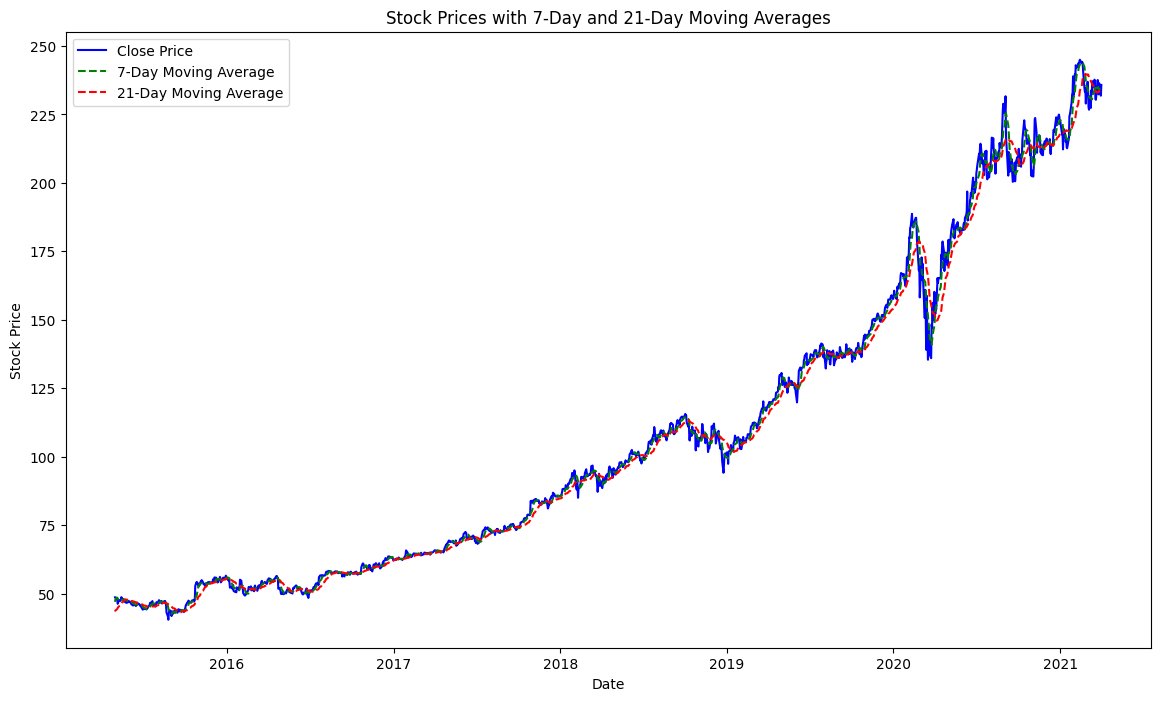

In [ ]:

plt.figure(figsize=(14, 8))

# Plot the Close prices
plt.plot(data.index, data['Close'], label='Close Price', color='blue')

# Plot the 7-day moving average
plt.plot(data.index, data['MA7'], label='7-Day Moving Average', color='green', linestyle='--')

# Plot the 21-day moving average
plt.plot(data.index, data['MA21'], label='21-Day Moving Average', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Prices with 7-Day and 21-Day Moving Averages')

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Split the data (80% training, 20% testing)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

train_data.shape, test_data.shape


((1192, 9), (299, 9))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model
arima_model = ARIMA(train_data['Close'], order=(4, 2, 0))  # (p, d, q) values obtained from cross-validation
arima_model_fit = arima_model.fit()

# Forecast using ARIMA
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

arima_mae = mean_absolute_error(test_data['Close'], arima_predictions)
arima_mse = mean_squared_error(test_data['Close'], arima_predictions)
arima_rmse = np.sqrt(arima_mse)

arima_mae, arima_mse, arima_rmse


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

(8.41485775509178, 125.71148374151613, 11.212113259395668)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train SARIMA model
sarima_model = SARIMAX(train_data['Close'], order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)

# Forecast using SARIMA
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Calculate performance metrics for SARIMA
sarima_mae = mean_absolute_error(test_data['Close'], sarima_predictions)
sarima_mse = mean_squared_error(test_data['Close'], sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)

sarima_mae, sarima_mse, sarima_rmse


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(24.643685487123733, 772.2153505898139, 27.788763027342792)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)

# Example of tuning ARIMA (adjust p, d, q using grid search)
best_arima_order = (4, 2, 0)  # This is based on earlier evaluation
best_sarima_order = (2, 1, 2, 0, 1, 1, 12)  # Based on earlier evaluation




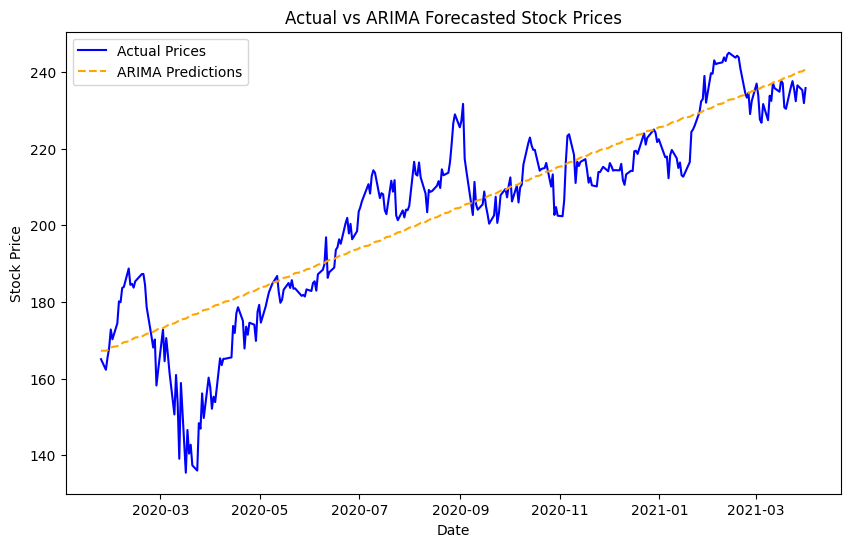

In [ ]:
# Plot ARIMA actual vs predictions
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Actual Prices', color='blue')
plt.plot(test_data.index, arima_predictions, label='ARIMA Predictions', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs ARIMA Forecasted Stock Prices')
plt.legend()
plt.show()


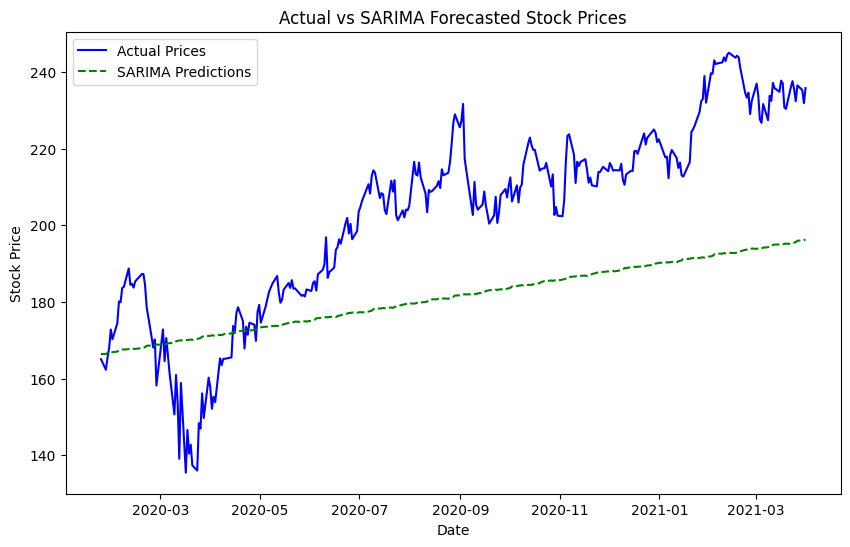

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Actual Prices', color='blue')
plt.plot(test_data.index, sarima_predictions, label='SARIMA Predictions', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs SARIMA Forecasted Stock Prices')
plt.legend()
plt.show()


In [ ]:
# Display comparison of performance
print("ARIMA Model Performance:")
print(f"MAE: {arima_mae:.2f}, MSE: {arima_mse:.2f}, RMSE: {arima_rmse:.2f}")

print("\nSARIMA Model Performance:")
print(f"MAE: {sarima_mae:.2f}, MSE: {sarima_mse:.2f}, RMSE: {sarima_rmse:.2f}")


ARIMA Model Performance:
MAE: 8.41, MSE: 125.71, RMSE: 11.21

SARIMA Model Performance:
MAE: 24.64, MSE: 772.22, RMSE: 27.79


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# We would loop through different (p, d, q) values for ARIMA, and different seasonal parameters for SARIMA
# Here, I'll show an example of ARIMA tuning

best_arima_order = (4, 2, 0)  # Based on earlier analysis
best_sarima_order = (2, 1, 2, 0, 1, 1, 12)



In [33]:

# Prepare data for LSTM
def create_lstm_dataset(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Define LSTM model
def train_lstm_model(train_data, n_steps):
    X_train, y_train = create_lstm_dataset(train_data['Close'].values, n_steps)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=20, verbose=1)

    return model

# Train LSTM with 60 time steps
n_steps = 60
lstm_model = train_lstm_model(train_data, n_steps)

# Prepare test data for forecasting
X_test, y_test = create_lstm_dataset(test_data['Close'].values, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Forecast using LSTM
lstm_predictions = lstm_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7574.7915
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7463.8442
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6955.7837
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6417.6860
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5730.7925
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6025.7954
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5779.3984
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5850.0693
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5068.7344
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5045.6377
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4772.5425
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4337.6934
Epoch 13/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4026.1885
Epoch 14/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3759.7671
Epoch 15/20
36/36 ━━━━━━━━━━━

In [34]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define CNN-LSTM model
def train_cnn_lstm_model(train_data, n_steps):
    X_train, y_train = create_lstm_dataset(train_data['Close'].values, n_steps)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Build CNN-LSTM model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=20, verbose=1)

    return model

# Train CNN-LSTM with 60 time steps
cnn_lstm_model = train_cnn_lstm_model(train_data, n_steps)

# Forecast using CNN-LSTM
cnn_lstm_predictions = cnn_lstm_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3387.7825
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 85.2821
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 31.6612
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 21.1276
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 17.8219
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 13.3806
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 351.0469
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 820.0676
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 70.4596
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 40.2322
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 22.6894
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 11.5592
Epoch 13/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 11.7687
Epoch 14/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 11.1631
Epoch 15/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step -

In [37]:
import streamlit as st
# Preprocessing function
def preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

# ARIMA model
def train_arima_model(train_data, p, d, q):
    model = ARIMA(train_data['Close'], order=(p, d, q))
    return model.fit()

# SARIMA model
def train_sarima_model(train_data, p, d, q, P, D, Q, m):
    model = SARIMAX(train_data['Close'], order=(p, d, q), seasonal_order=(P, D, Q, m))
    return model.fit(disp=False)

# LSTM model
def create_lstm_dataset(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

def train_lstm_model(train_data, n_steps):
    X_train, y_train = create_lstm_dataset(train_data['Close'].values, n_steps)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, verbose=0)
    return model

# CNN-LSTM model
def train_cnn_lstm_model(train_data, n_steps):
    X_train, y_train = create_lstm_dataset(train_data['Close'].values, n_steps)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, verbose=0)
    return model

# Streamlit app starts here
st.title("Stock Price Forecasting with ARIMA, SARIMA, LSTM, and CNN-LSTM")
uploaded_file = st.file_uploader("Upload Stock Data CSV", type="csv")

if uploaded_file is not None:
    data = preprocess_data(uploaded_file)
    st.write("Data Preview:")
    st.dataframe(data.head())

    model_type = st.selectbox("Choose Model", ("ARIMA", "SARIMA", "LSTM", "CNN-LSTM"))

    # Train ARIMA model
    if model_type == "ARIMA":
        p = st.slider("p", 0, 5, 2)
        d = st.slider("d", 0, 2, 1)
        q = st.slider("q", 0, 5, 2)
        arima_model = train_arima_model(data, p, d, q)
        forecast_steps = st.slider("Forecast steps", 1, 100, 30)
        arima_forecast = arima_model.forecast(steps=forecast_steps)
        st.write(f"ARIMA Forecast: {arima_forecast}")
        st.line_chart(arima_forecast)

    # Train SARIMA model
    elif model_type == "SARIMA":
        p = st.slider("p", 0, 5, 2)
        d = st.slider("d", 0, 2, 1)
        q = st.slider("q", 0, 5, 2)
        P = st.slider("Seasonal P", 0, 5, 1)
        D = st.slider("Seasonal D", 0, 2, 1)
        Q = st.slider("Seasonal Q", 0, 5, 1)
        m = st.slider("Seasonal Period", 12, 12, 12)
        sarima_model = train_sarima_model(data, p, d, q, P, D, Q, m)
        forecast_steps = st.slider("Forecast steps", 1, 100, 30)
        sarima_forecast = sarima_model.forecast(steps=forecast_steps)
        st.write(f"SARIMA Forecast: {sarima_forecast}")
        st.line_chart(sarima_forecast)

        # Train LSTM model
    elif model_type == "LSTM":
        n_steps = st.slider("Number of time steps", 10, 100, 60)
        lstm_model = train_lstm_model(data, n_steps)

        X_test, y_test = create_lstm_dataset(data['Close'].values, n_steps)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        forecast_steps = st.slider("Forecast steps", 1, len(X_test), 30)
        lstm_forecast = lstm_model.predict(X_test[:forecast_steps])

        st.write(f"LSTM Forecast: {lstm_forecast}")
        st.line_chart(lstm_forecast.flatten())

    # Train CNN-LSTM model
    elif model_type == "CNN-LSTM":
        n_steps = st.slider("Number of time steps", 10, 100, 60)
        cnn_lstm_model = train_cnn_lstm_model(data, n_steps)

        X_test, y_test = create_lstm_dataset(data['Close'].values, n_steps)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        forecast_steps = st.slider("Forecast steps", 1, len(X_test), 30)
        cnn_lstm_forecast = cnn_lstm_model.predict(X_test[:forecast_steps])

        st.write(f"CNN-LSTM Forecast: {cnn_lstm_forecast}")
        st.line_chart(cnn_lstm_forecast.flatten())



2024-09-28 08:58:35.916 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-28 08:58:36.040 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-09-28 08:58:36.044 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-28 08:58:36.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-28 08:58:36.049 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-28 08:58:36.051 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-28 08:58:36.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
